### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [2]:
# for data reading and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

# for deep learning
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, models, callbacks, optimizers, losses
from tensorflow.keras.preprocessing.text import Tokenizer

# for saving models and training instants
import pickle 

### Load Datasets

In [3]:
# change working directory to the project folder on google drive
%cd '/content/drive/MyDrive/Machine Learning/AIM Task'

/content/drive/MyDrive/Machine Learning/AIM Task


In [4]:
# read train and test csv files
train = pd.read_csv('data/train.csv', lineterminator='\n')
test = pd.read_csv('data/test.csv', lineterminator='\n')

In [5]:
# assign data inputs and targets
X_train = train['text']
y_train = train['target\r']

X_test = test['text']
y_test = test['target\r']

### Machine Learning Modeling

- logically, dialects can be classified through the unique words for each dialect or unique expressions of 2 words, so `ngram range 1 to 2` will be suitable for this case. In addition, we need to ignore the high existance words and focus on the rare and unique ones, so `TFIDF count vectorized` will be suitable for this case.
- As we deal with high dimensions, `Linear SVM Classifier` is a good model to deal with our data.

In [6]:
# create Tfidf Count Vectorizer and apply on data
tfidf_vec = TfidfVectorizer(ngram_range=(1, 2))

# create svm instant and train
svc_clf = LinearSVC(verbose=1)

# create a pipeline
pipe = make_pipeline(tfidf_vec, svc_clf)

In [7]:
# train the model
pipe.fit(X_train, y_train)

[LibLinear]

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('linearsvc', LinearSVC(verbose=1))])

In [8]:
# evaluate the model
y_pred1 = pipe.predict(X_test)
acc1 = accuracy_score(y_test, y_pred1)
f1_score1 = f1_score(y_test, y_pred1, average='macro')

print(classification_report(y_test, y_pred1))
print('Accuracy: {:0.3f}'.format(acc1))
print('F1-score: {:0.3f}'.format(f1_score1))

              precision    recall  f1-score   support

           0       0.45      0.45      0.45      1307
           1       0.39      0.30      0.34      1301
           2       0.65      0.55      0.59       805
           3       0.67      0.88      0.76      2868
           4       0.67      0.57      0.61       765
           5       0.43      0.34      0.38      1389
           6       0.49      0.63      0.55      2094
           7       0.63      0.70      0.66      1376
           8       0.68      0.70      0.69      1820
           9       0.79      0.58      0.67       574
          10       0.46      0.36      0.40       947
          11       0.50      0.56      0.53      2180
          12       0.49      0.51      0.50      1549
          13       0.44      0.47      0.45      1328
          14       0.77      0.59      0.67       718
          15       0.52      0.30      0.38       805
          16       0.71      0.44      0.55       460
          17       0.48    

In [9]:
# save model pipeline
pickle.dump(pipe, open('models/svm_pipeline.pkl', 'wb'))

### Deep Learning Modeling

- Fine-tuned Transformers are the best option to solve such a problem, but due to the poor computational power we will train using RNNs, especialy `Bi-directional LSTM model` to capture the sequence of the texts in both directions and deal with long texts.

In [10]:
# check the number of unique tokens 'words' in data
countVec = CountVectorizer()
countVec.fit(X_train)
len(countVec.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


397308

In [11]:
# check the max sequence length in our data
max_sequence_len = 0
for text in X_train:
    max_sequence_len = max(len(text), max_sequence_len)

print(max_sequence_len)

280


In [12]:
# determine the vocab size and max sequence len
vocab_size = 150000
max_sequence_len = 20

In [13]:
# data tokenization
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list(X_train))

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [14]:
# data padding
X_train_padded = sequence.pad_sequences(X_train_token, maxlen=max_sequence_len)
X_test_padded = sequence.pad_sequences(X_test_token, maxlen=max_sequence_len)

In [15]:
# check padded data shapes
print(X_train_padded.shape)
print(X_test_padded.shape)

(432786, 20)
(22779, 20)


In [16]:
# model architecture
bi_lstm = models.Sequential([    
                            layers.Embedding(vocab_size, 64),
                            layers.Bidirectional(layers.LSTM(64)),
                            layers.Flatten(),
                            layers.Dense(64, activation='relu'),
                            layers.Dropout(0.5),
                            layers.Dense(18, activation='softmax')
])

# compile
bi_lstm.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# early stop function
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [17]:
# # train the model 
history = bi_lstm.fit(X_train_padded, y_train,
                  validation_data=(X_test_padded, y_test),
                  epochs=10, callbacks=[early_stop])

Epoch 1/10
13525/13525 [==============================] - 271s 19ms/step - loss: 1.9493 - accuracy: 0.3842 - val_loss: 1.6690 - val_accuracy: 0.4714
Epoch 2/10
13525/13525 [==============================] - 256s 19ms/step - loss: 1.4940 - accuracy: 0.5371 - val_loss: 1.5894 - val_accuracy: 0.5062
Epoch 3/10
13525/13525 [==============================] - 253s 19ms/step - loss: 1.2058 - accuracy: 0.6334 - val_loss: 1.6529 - val_accuracy: 0.5099
Epoch 4/10
13525/13525 [==============================] - 255s 19ms/step - loss: 0.9779 - accuracy: 0.7075 - val_loss: 1.7889 - val_accuracy: 0.5048
Epoch 5/10
13525/13525 [==============================] - 253s 19ms/step - loss: 0.8003 - accuracy: 0.7630 - val_loss: 2.0196 - val_accuracy: 0.4978


In [18]:
# evaluate the model
y_pred2 = np.argmax(bi_lstm.predict(X_test_padded),axis = 1)
acc2 = accuracy_score(y_test, y_pred2)
f1_score2 = f1_score(y_test, y_pred2, average='macro')

print(classification_report(y_test, y_pred2))
print('Accuracy: {:0.3f}'.format(acc2))
print('F1-score: {:0.3f}'.format(f1_score2))

              precision    recall  f1-score   support

           0       0.46      0.34      0.39      1307
           1       0.34      0.22      0.27      1301
           2       0.62      0.46      0.53       805
           3       0.65      0.85      0.74      2868
           4       0.59      0.51      0.55       765
           5       0.46      0.13      0.21      1389
           6       0.40      0.63      0.49      2094
           7       0.60      0.61      0.61      1376
           8       0.60      0.70      0.64      1820
           9       0.75      0.53      0.62       574
          10       0.46      0.27      0.34       947
          11       0.41      0.61      0.49      2180
          12       0.48      0.46      0.47      1549
          13       0.33      0.42      0.37      1328
          14       0.80      0.53      0.64       718
          15       0.40      0.31      0.35       805
          16       0.79      0.36      0.50       460
          17       0.41    

In [19]:
# save model and weights
bi_lstm.save('models/bi_lstm', save_format='h5')
bi_lstm.save_weights('models/trained_bi_lstm_ckpt')

### Results

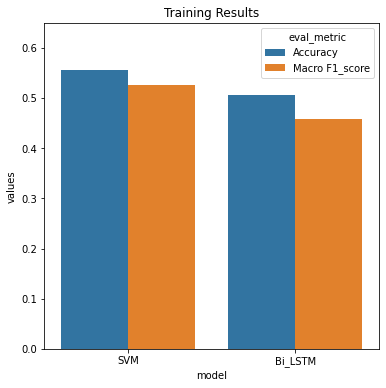

In [20]:
# visualize results
results_df = pd.DataFrame({
                            'model' : ['SVM']*2 + ['Bi_LSTM']*2,
                            'eval_metric':['Accuracy', 'Macro F1_score']*2, 
                            'values':[acc1, f1_score1, acc2, f1_score2] 
                           })

plt.figure(figsize=(6,6))
sns.barplot(data=results_df, x='model',y='values', hue='eval_metric')
plt.title('Training Results')
plt.ylim(0, 0.65);

- In comparison, `SVM is better than Bi-LSTM and more accurate` in this problem case.

### Done!